# Банки — Анализ оттока клиентов

## Презентация

* Ссылка на презетацию: https://drive.google.com/file/d/1f19fuIbaPlO6aIio1YUBCg3ZP20jOnJ5/view?usp=sharing

## Описание проекта

**Цель проекта:** проанализировать клиентов регионального банка «Метанпром» и выделить портрет клиентов, которые склонны попадать в отток.

**Задачи:**
1. Провести исследовательский анализ данных.
2. Выделить портреты клиентов, которые склонны уходить из банка.
3. Сформулировать и проверить статистические гипотезы:
- Гипотеза различия дохода между теми клиентами, которые ушли и теми, которые остались.
- Гипотеза о различии возраста между теми клиентами, которые ушли и теми, которые остались.
4. Предложить меры по снижению оттока.
5. Подготовить дашборд и презентацию по результатам исследования для продакт-менеджера.

**Описание данных**

Заказчик подготовил для нас файл, который содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.
Набор данных включает следующие поля:
* Userid — идентификатор пользователя;
* Score — баллы кредитного скоринга;
* City — город;
* Gender — пол;
* Age — возраст;
* Objects — количество объектов в собственности;
* Balance — баланс на счете;
* Products — количество продуктов, которыми пользуется клиент;
* CreditCard — есть ли кредитная карта;
* Loyalty — активный клиент;
* Estimated_salary — заработная плата клиента;
* Churn — ушел или нет.

## Загрузим данные

**Импортируем необходимые библиотеки для исследования**

In [1]:
import pandas as pd # для анализа данных
import numpy as np # для математических вычислений
import math as mth # для математических вычислений

import seaborn as sns # для визуализации данных
import matplotlib.pyplot as plt # для визуализации данных
import plotly.express as px # для визуализации данных

from sklearn.preprocessing import StandardScaler # для стандартизации данных
from sklearn.model_selection import train_test_split # разделение на обучающую и тестовую выборки
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.metrics import roc_auc_score # метрики качества
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # метрики качества
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # метрики качества
from sklearn.cluster import KMeans # K-Means кластеризация
from scipy.cluster.hierarchy import dendrogram, linkage # кластеризация
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier # дерево принятия решений
from sklearn.ensemble import RandomForestRegressor # случайный лес
from sklearn.ensemble import RandomForestClassifier # случайный лес
from scipy import stats as st # А/Б-тесты

import warnings # для предупреждений
warnings.filterwarnings('ignore') # фильтр предупреждений

**Прочитаем данные из файла и сохраним их**

In [2]:
data = pd.read_csv('/datasets/bank_dataset.csv')

**С помощью pd.option настроим вывод так, чтобы текст в ячейке отражался полностью вне зависимости от длины, числа отражались с двумя знаками после запятой**

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.float_format = '{:.2f}'.format

**Посмотрим содержимое таблицы data, выведем общую информацию и проверим наши данные на наличие пропусков и дубликатов**

In [4]:
def total_info(df, name_list):
    print('\033[1m' + 'Первые 5 строк таблицы', name_list + '\033[0m')
    display(df.head(5))
    
    print('\033[1m' + 'Общая информация таблицы', name_list + '\033[0m')
    display(df.info())
    
    print('\033[1m' + 'Hаличие дубликатов в таблице', name_list + '\033[0m')
    display(df.duplicated().sum())
    
total_info(data, 'data')

Первые 5 строк таблицы data


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Общая информация таблицы data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None

Hаличие дубликатов в таблице data


0

**Посмотрим наличие пропусков в таблице**

In [5]:
report = data.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / data.shape[0]*100).round(2)
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
Balance,3617,36.17
userid,0,0.00
score,0,0.00
City,0,0.00
Gender,0,0.00
Age,0,0.00
Objects,0,0.00
Products,0,0.00
CreditCard,0,0.00
Loyalty,0,0.00


* Всего в таблице 10000 строк (наблюдений) и 12 столбцов, встречаются следующие типы данных: int64, float64, object.
* Дубликатов не обнаружили, в столбце balance есть пропущенные значения. Причина появления пропусков может иметь технический характер, то есть клиент не имеет дебетовой карты и отображается в нашей системе таким образом. Мы не можем удалить эти пропуски, так как их доля составляет 36% и при удалении мы потерям ценные данные, поэтому посмотрим есть ли в столбце balance нулевые значения и подумаем, что мы можем сделать.
* Приведем столбцы к нижнему регистру. 
* Изменим типы данных в столбцах gender (пол) и city (город), сделаем их бинарными.

**Приведем наименования всех колонок к нижнему регистру**

In [6]:
data.columns = data.columns.str.lower()

**Вернемся к столбцу balance, выведем количество отсутствующих значений**

In [7]:
print('Строк с отсутствующими значенеиями в столбце balance:', data['balance'].isna().sum())

Строк с отсутствующими значенеиями в столбце balance: 3617


В столбце, который отражает баланс на счетах наших клиентов, 3617 строк с отсутствующими значениями.

**Посмотрим на нулевые значения в столбце balance**

In [8]:
len(data[data['balance'] == 0])

0

В столбце balance есть пропущенные значения, при этом нулевых нет.

**Тогда выведем минимальный баланс на счете**

In [9]:
print('Минимальный баланс на счете клиента:', data['balance'].min(), 'рублей')

Минимальный баланс на счете клиента: 3768.69 рублей


Минимальный баланс на счете клиента равен 3768.69 рублей. Можем предположить, что эти пропуски все-таки как раз отражают отсутствие денег на балансе, то есть клиент пользуется услугами банка, но не держит на счете деньги, поэтому пока создадим копию нашей таблицы, заменим пропуски на нули и постараемся получше разобраться в природе появления таких значений, возможно, увидим какие-то закономерности.

In [10]:
# cоздадим копию таблицы data и заменим пропуски на нули в столбце balance
data_copy = data.copy()
data_copy['balance'].replace(np.nan, 0, inplace=True)

# создадим столбец, который будет показывать, что у клиента нет счета (баланс равен 0)
data_copy['account'] = data_copy['balance'].copy() 
data_copy.account = data_copy.account.astype(np.int64)
data_copy.loc[(data_copy['account'] != 0), 'account'] = 1
data_copy.head()

# cоздадим отдельный датафрейм
no_balance = data_copy[data_copy['balance'] == 0]
no_balance.head(5)

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,account
0,15677338,619,Ярославль,Ж,42,2,0.00,1,1,1,101348.88,1,0
3,15744090,699,Ярославль,Ж,39,1,0.00,2,0,0,93826.63,0,0
6,15635267,822,Ярославль,М,50,7,0.00,2,1,1,10062.80,0,0
11,15779909,497,Рыбинск,М,24,3,0.00,2,1,0,76390.01,0,0
12,15675000,476,Ярославль,Ж,34,10,0.00,2,1,0,26260.98,0,0


**Посмотрим в каких городах у нас встречаются пропуски значений баланса на счетах клиентов**

In [11]:
no_balance['city'].value_counts()

Ярославль    2418
Рыбинск      1199
Name: city, dtype: int64

Пропуски видим в двух городах - это Ярославль (почти 67%) и Рыбинск - 33%.

**Посмотрим сколько клиентов у нас попало в отток**

In [12]:
no_balance['churn'].value_counts()

0    3117
1     500
Name: churn, dtype: int64

Видим, что у нас 500 клиентов ушли в отток (около 14%), то есть такие клиенты все-таки в большинстве остаются.

**Теперь посмотрим на маркер "активности" клиентов за последнее время**

In [13]:
no_balance['loyalty'].value_counts()

1    1873
0    1744
Name: loyalty, dtype: int64

Среди таких клиентов у нас те, кто ушли и остались почти равны.

**Посмотрим наличие кредитной карты у таких клиентов**

In [14]:
no_balance['creditcard'].value_counts()

1    2592
0    1025
Name: creditcard, dtype: int64

Видим, что почти у 72% таких клиентов есть кредитная карта. В целом, можем предположить, что действительно система дает некий сбой, который происходит не во всех городах, поэтому перед построением моделей мы заполним пропущенные значения нулевыми, но какую-то ставку на эту переменную в модели делать не будем (все-таки метод довольно радикальный).

**Проверим количество уникальных клиентов в датасете**

In [15]:
len(data['userid'].unique())

10000

Отлично, каждая строка в нашем датасете - это данные по уникальному клиенту.

**Также в наших данных представлены значения по такому показателю как кредитный скоринг. Кредитный скоринг – это алгоритм, который помогает объективно оценить, стоит ли выдавать заем конкретному клиенту. Посмотрим на значения минимального и максимального балла кредитного скоринга в нашем банке**

In [16]:
print('Минимальный балл кредитного скоринга:', data['score'].min())
print('Максимальный балл кредитного скоринга:', data['score'].max())

Минимальный балл кредитного скоринга: 350
Максимальный балл кредитного скоринга: 850


«Метанпром» используют шкалу Национального бюро кредитных историй (НБКИ), интервал которой составляет от 300 до 850 баллов, где 300-500 - нет шансов получить заем, 500-650 - это довольно низкий балл и крупные финансовые организации не рассматривают, 650-690 - хороший балл, есть шансы на одобрение займа со стандартными условиями и 690-850 - это отличный балл, одобрить заем могут с более выгодными условиями. (Источник: https://sovcombank.ru/blog/krediti/skoring-v-banke-chto-eto-takoe-prostimi-slovami). Так же бывают и другие вариации баллов, однако каких-то аномальных значений мы здесь не видим.

**Напишем функцию, которая рапределит нам клиентов на категории по уровню кредитного скоринга в соотвествии со шкалой НБКИ, чтобы посмотреть наши данные получше**

Хороший балл     5885
Отличный балл    3472
Низкий балл       643
Name: score_category, dtype: int64

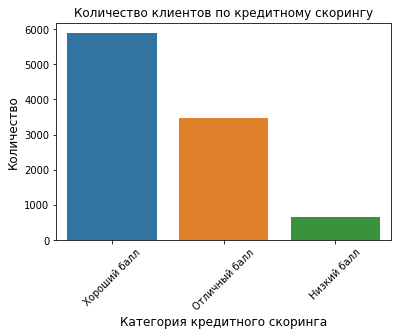

In [17]:
def score_category(data):
    
    if data['score'] <= 500: # <= 500 - низкий балл, нет шансов получить заем
        return 'Низкий балл'
    
    elif data['score'] <= 690: # <= 690 - хороший балл, стандартные условия
        return 'Хороший балл'
    
    else:
        return 'Отличный балл' # остальные - отличный балл, выгодные условия

# добавим столбец в таблицу
data['score_category'] = data.apply(score_category, axis=1)

# построим график
display(data['score_category'].value_counts())
sns.countplot(x = 'score_category', data = data)
plt.title('Количество клиентов по кредитному скорингу', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Категория кредитного скоринга', fontsize=12)
plt.xticks(rotation = 45)
plt.show()

Видим, что большинство клиентов (почти 59%) у нас имеют хороший балл кредитного рейтинга, отличный балл - около 35% клиентов.

**Теперь посмотрим на демографические характеристики: количество клиентов по городам, количество мужчин и женщин, минимальный и максимальный возраст клиентов**

**Посмотрим на количество клиентов по городам**

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

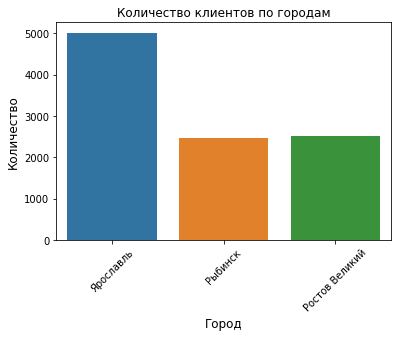

In [18]:
display(data['city'].value_counts())

# построим график
sns.countplot(x = 'city', data = data)
plt.title('Количество клиентов по городам', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Город', fontsize=12)
plt.xticks(rotation= 45)
plt.show()

Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. В нашем датасете содержится информация о клиентах из всех городов. Половина всех клиентов из нашей выборки проживают в Ярославле (5014 человек), затем идет Ростов (2509 человек - 25%) и Рыбинск (2477 - около 25%).

**Посмотрим на количество мужчин и женщин, построим диаграмму размаха по возрасту и полу клиентов**

М    5457
Ж    4543
Name: gender, dtype: int64

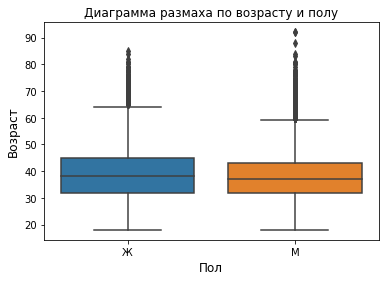

In [19]:
display(data['gender'].value_counts())

# построим график
ax = sns.boxplot(x = 'gender', y = 'age', data = data)
plt.title('Диаграмма размаха по возрасту и полу', fontsize=12)
plt.ylabel('Возраст', fontsize=12)
plt.xlabel('Пол', fontsize=12)
plt.show()

Видим, что мужчин у нас почти 55% выборки (5457 человек). Их больше на 914, чем женщин. Так же по графику видим, что мужчины немного моложе, чем женщины.

**Выведем минимальный и максимальный возраст**

In [20]:
print('Минимальный возраст клиента:', data['age'].min(), 'лет')
print('Максимальный возраст клиента:', data['age'].max(), 'года')

Минимальный возраст клиента: 18 лет
Максимальный возраст клиента: 92 года


Все наши клиенты совершеннолетние, проблем с данными нет.

**Напишем функцию, которая распределит клиентов по возрастным категориям**

Средний возраст    7232
Молодой            1968
Пожилой             800
Name: age_category, dtype: int64

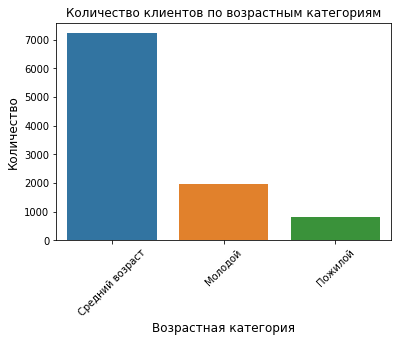

In [21]:
def age_category(data):
    
    if data['age'] <= 30:
        return 'Молодой' # от 18 до 30 - молодой
    
    elif data['age'] <= 55:
        return 'Средний возраст' # - зрелый, средний возраст
    
    else:
        return 'Пожилой' # остальные

# добавим столбец в таблицу
data['age_category'] = data.apply(age_category, axis=1)
display(data['age_category'].value_counts())

# построим график
sns.countplot(x = 'age_category', data = data)
plt.title('Количество клиентов по возрастным категориям', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Возрастная категория', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Видим, что у нас больше клиентов среднего возраста - 72%, затем идет категория "молодые" - в нее попадает около 20% наших клиентов, пожилых у нас 8%.

**Посмотрим на количество объектов в собственности**

In [22]:
data['objects'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: objects, dtype: int64

У наших клиентов от 0 до 10 объектов в собственности.

**Напишем функцию для категоризации клиентов по количеству объектов в собственности**

Боле 5 объектов    4494
3-5 объектов       3010
1-2 объекта        2083
Нет объектов        413
Name: objects_category, dtype: int64

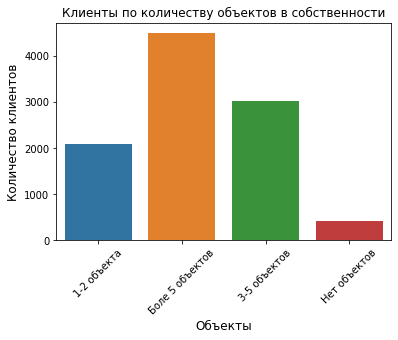

In [23]:
def objects_category(data):
    
    if data['objects'] == 0: # нет объектов в собственности
        return 'Нет объектов'
    
    elif data['objects'] < 3: # 1-2 объекта
        return '1-2 объекта'
    
    elif data['objects'] <= 5: # 3-5 объектов
        return '3-5 объектов'
    
    else:
        return 'Боле 5 объектов' # более 5, довольно много объектов

# добавим столбец в таблицу
data['objects_category'] = data.apply(objects_category, axis=1)
display(data['objects_category'].value_counts())

# построим график
sns.countplot(x = 'objects_category', data = data)
plt.title('Клиенты по количеству объектов в собственности', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.xlabel('Объекты', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Видим, что у большинства клиентов более 5 объектов в собственности, но довольно много и тех, у кого 3-5.

**Теперьт напишем функцию, которая распределяет клиентов по категориям в зависимости от их баланса на счете**

Более 150000       4586
100000 - 150000    3830
50000 - 100000     1509
Менее 50000          75
Name: balance_category, dtype: int64

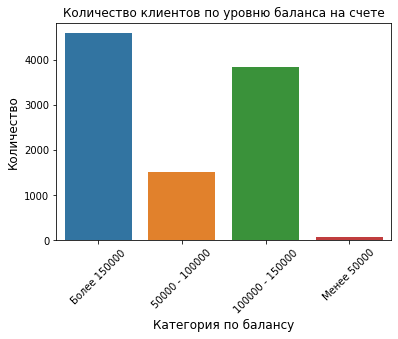

In [24]:
def balance_category(data):
    
    if data['balance'] < 50000:
        return 'Менее 50000'
    
    elif data['balance'] <= 100000:
        return '50000 - 100000'
    
    elif data['balance'] <= 150000:
        return '100000 - 150000'
    
    else:
        return 'Более 150000'

# добавим столбец в таблицу
data['balance_category'] = data.apply(balance_category, axis=1)

# построим график
display(data['balance_category'].value_counts())
sns.countplot(x = 'balance_category', data = data)
plt.title('Количество клиентов по уровню баланса на счете', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Категория по балансу', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Видим, что больше всего у нас клиентов на счете у которых более 100000 рублей.

**Теперь посмотрим на количество продуктов, которыми пользуются клиенты:**

1    5084
2    4590
3     266
4      60
Name: products, dtype: int64

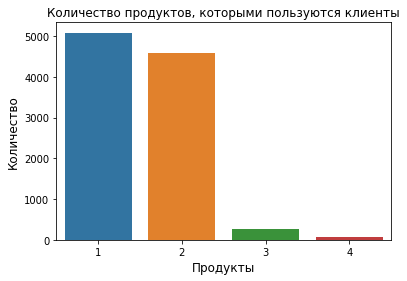

In [25]:
display(data['products'].value_counts())

# построим график
sns.countplot(x = data['products'], data = data)
plt.title('Количество продуктов, которыми пользуются клиенты', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Продукты', fontsize=12)
plt.show()

В нашей выборке более популярны 1-2 продукта - суммарно ими пользуются 9674 клиента из 10000, то есть почти 97%. Интересно было бы узнать, что именно за продукты мы предоставляем клиентам.

**Посмотрим на количество клиентов в нашей выборке по наличию/отсутствию кредитной карты**

In [26]:
data['creditcard'].value_counts()

1    7055
0    2945
Name: creditcard, dtype: int64

Большинство наших клиентов имеют кредитную карту (около 71% клиентов).

**Посмотрим на количество клиентов по активности, отсутствию активности**

In [27]:
data['loyalty'].value_counts()

1    5151
0    4849
Name: loyalty, dtype: int64

Больше половины наших клиентов (около 52%) активно пользуются услугами банка, то есть взаимодействовали с продуктами.

**Выведем минимальную и максимальную заработную плату наших клиентов**

In [28]:
print('Минимальный заработная плата клиента:', data['estimated_salary'].min(), 'рублей')
print('Максимальный заработная плата клиента:', data['estimated_salary'].max(), 'рубля')

Минимальный заработная плата клиента: 11.58 рублей
Максимальный заработная плата клиента: 199992.48 рубля


В нашей выборке минимальная заработная плата выглядит низкой, так как с 1 января 2022 года минимальный размер оплаты труда (МРОТ) составит 13890 рублей в месяц (Источник: http://duma.gov.ru/news/53151/). Возможно, что какие-то наши клиенты являются безработными, самозанятым и пр., но, вероятно, эти данные просто не были предоставлены и значения были рассчитаны специальной моделью. Посмотрим на данные в нашей выборке, где заработная плата ниже минимальной по стране.

**Посмотрим на значения, где зарплата ниже чем МРОТ**

In [29]:
data_salary = data[data['estimated_salary'] < 13890]
data_salary.sample(10)

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,score_category,age_category,objects_category,balance_category
4215,15616949,789,Ярославль,Ж,53,1,158271.74,1,1,1,5036.39,1,Отличный балл,Средний возраст,1-2 объекта,Более 150000
3172,15735555,665,Ростов Великий,М,32,1,132178.67,1,0,0,11865.76,0,Хороший балл,Средний возраст,1-2 объекта,100000 - 150000
5165,15731348,850,Ярославль,М,33,7,140956.99,1,0,0,3510.18,0,Отличный балл,Средний возраст,Боле 5 объектов,100000 - 150000
7141,15685792,755,Ростов Великий,Ж,38,1,82083.52,1,0,1,10333.78,0,Отличный балл,Средний возраст,1-2 объекта,50000 - 100000
276,15737192,756,Ярославль,М,62,3,NaN,1,1,1,11199.04,1,Отличный балл,Пожилой,3-5 объектов,Более 150000
4231,15821683,628,Ярославль,М,36,3,NaN,2,1,1,8742.91,0,Хороший балл,Средний возраст,3-5 объектов,Более 150000
1607,15691457,711,Ярославль,М,64,4,NaN,2,1,1,3185.67,0,Отличный балл,Пожилой,3-5 объектов,Более 150000
2726,15849781,829,Ростов Великий,Ж,37,3,103457.76,1,0,0,1114.12,0,Отличный балл,Средний возраст,3-5 объектов,100000 - 150000
2641,15642037,538,Ростов Великий,Ж,28,6,164365.44,1,0,1,5698.97,0,Хороший балл,Молодой,Боле 5 объектов,Более 150000
9173,15696308,673,Рыбинск,М,43,8,127132.96,1,0,1,6009.27,1,Хороший балл,Средний возраст,Боле 5 объектов,100000 - 150000


**Узнаем сколько таких клиентов**

In [30]:
len(data_salary)

694

694 строки из 10000 - это не критично, но мы видим, что есть клиенты чей доход ниже МРОТ, а на счете у них лежат довольно крупные суммы и количество объектов в собственности. Сотрудникам банка следует обратить внимание и более подробно изучить причины такой аномалии, если часть этих данных была получена в результате оценки некой модели, то ее стоит доработать.

**Посмотрим на количество клиентов по городам**

In [31]:
display(data_salary['city'].value_counts())

Ярославль         351
Рыбинск           178
Ростов Великий    165
Name: city, dtype: int64

Клиенты с заработной платой ниже МРОТ в большой степени проживают в Ярославле (351 человек - 51%), затем идет Рыбинск (около 26%) и Ростов Великий (около 23%).

**Теперь посмотрим сколько клиентов ушли в отток**

In [32]:
data_salary['churn'].value_counts()

0    558
1    136
Name: churn, dtype: int64

Среди таких клиентов 136 ушли в отток, около 20%.

**Напишем функцию, которая распределит клиентов по уровню заработной платы/дохода**

Высокий доход          5010
Средний доход          2537
Доход ниже средного    2453
Name: estimated_salary_category, dtype: int64

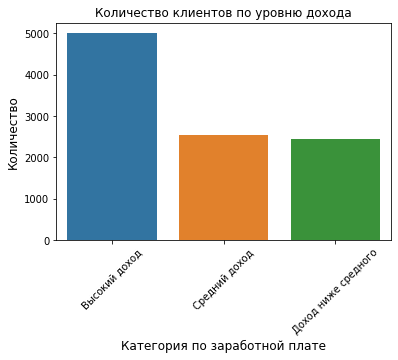

In [33]:
def salary_category(data):
    
    if data['estimated_salary'] <= 50000: # заработная плата ниже средней по стране
        return 'Доход ниже средного'
    
    elif data['estimated_salary'] <= 100000: # средний уровень дохода
        return 'Средний доход'
    
    else:
        return 'Высокий доход' # высокий уровень дохода

# добавим столбец в таблицу
data['estimated_salary_category'] = data.apply(salary_category, axis=1)
display(data['estimated_salary_category'].value_counts())

# построим график
sns.countplot(x = 'estimated_salary_category', data = data)
plt.title('Количество клиентов по уровню дохода', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Категория по заработной плате', fontsize=12)
plt.xticks(rotation = 45)
plt.show()

Видим, что больше всего у нас клиентов с доходом выше среднего.

**Посмотрим на соотношение ушедших в отток клиентов и оставшихся**

In [34]:
data['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

В отток пока ушло намного меньше клиентов, чем тех, кто все еще с нами.

**Преобразуем категориальные переменные gender и city в числовые, сделаем их бинарными и изменим тип данных**

In [35]:
data['gender'] = data['gender'].replace('Ж','0').replace('М','1').astype('int')
data['city'] = data['city'].replace('Ярославль','1').replace('Ростов Великий','2').replace('Рыбинск','3').astype('int')

Теперь данные готовы для дальнейшего анализа.

**Вывод**

Заказчик подготовил для нас файл, который содержит данные с информацией о клиентах банка «Метанпром» за предыдущий до проверки факта оттока период. Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. 

Данные представлены в виде таблицы, включающей в себя 10000 строк и 12 столбцов, в которых содержится следующая информация: идентификатор пользователя, баллы кредитного скоринга клиентов, город, пол, возраст, количество объектов в собственности, баланс на счете, количество продуктов, которыми пользуется клиент, есть ли у него кредитная карта, является ли он активным (пользовался услугами нашего банка в последнее время), заработная плата клиента, а также ушел или нет (факт оттока). 

На этапе подготовки данных названия столбцов в таблице были приведены к нижнему регистру, преобразовали категориальные переменные пол и город в числовые, изменили их типы данных. Дубликатов в наших данных не обнаружили. 

В столбце balance увидели пропущенные значения, так как мы не можем удалить эти пропуски (их доля составляет 36% и при удалении мы потерям ценные данные), мы также выявили, что в данном столбце при наличии пропущенных значений нет нулевых, а минимальный баланс на счете клиента равен 3768.69 рублей, при этом учитывая, что отсутствие значений встречается не во всех городах, у большинства клиентов есть кредитная карта, мы предположили, что эти пропуски отражают отсутствие денег на балансе, то есть клиент пользуется продуктами банка, но не держит деньги на счете, однако, все-таки ставку на эту переменную в модели делать не будем.

## Проведем исследовательский анализ данных (EDA)

### Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения

Вызовем метод describe() и посмотрим на  параметры загруженных данных. Для удобства отображения мы транспонируем: поменяем местами столбцы и строки.

Обратим внимание на общие статистики показателей в данных:
* count - количество значений, которые не являются пропущенными;
* mean, std - среднее и разброс данных в соответствующем поле;
* остальные статистики - минимальное и максимальное значения, квантили.

In [36]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,10000.00,15733676.57,71936.19,15608437.00,15671264.25,15733474.00,15795969.75,15858426.00
score,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
city,10000.00,1.75,0.83,1.00,1.00,1.00,2.00,3.00
gender,10000.00,0.55,0.50,0.00,0.00,1.00,1.00,1.00
age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
objects,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
balance,6383.00,119827.49,30095.06,3768.69,100181.98,119839.69,139512.29,250898.09
products,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
creditcard,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00


* В данной выборке у нас все клиенты уникальные и их 10 000 человек.
* Средний балл кредитного скоринга равен 650 (score). Это хороший балл, он позволяет оформить займ со стандартными условиями, хотя, как мы видели, разброс здесь достаточно большой.
* Половина клиентов у нас из Ярославля (1), остальные - из Ростова (2) и Рыбинска (3).
* Почти одинаковое распределение по полу, хотя мужчин немного больше - их 55% от всей выборки (gender).
* Клиентам от 18 до 92 лет, при этом средний возраст - 38 лет (age).
* Среднее количество объектов в собственности у клиентов - 5 (objects). Ранее мы также видели, что у большинства клиентов более 5 объектов в собственности, но довольно много и тех, у кого 3-5.
* Средняя сумма на счете равна 119827 рублей. Ранее также видели, что у нас действительно довольно много клиентов у кого на балансе 100000-150000 у.е и больше.
* В среднем клиенты пользуются - 1-2 продуктами (products).
* В среднем клиенты имеют кредитную карту - 71% (creditсard).
* 52% клиентов активны, то есть пользовались нашими продуктами в последнее время (loyalty).
* Заработная плата в среднем 100000 рублей. Это довольно неплохо, учитывая, что наш банк расположен не в самых крупных по населению городах. Мы также видели, что у нас довольно много клиентов с высоким доходом (более 100000 у.е.).
* Доля оттока 20%. Значит в нашей выборке 20% клиентов ушли.

В датасете нет отсутствующих признаков. Стандартное отклонение очень разные у переменных score, age, objects, balance, products, estimated_salary. Возможно, что на это надо будет обратить внимание в дальнейшем.

### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуемся методом groupby()). Оставшиеся клиенты - 0, ушли в отток - 1

In [37]:
data_mean = data.groupby('churn').agg('mean').T
data_mean

churn,0,1
userid,15733903.88,15732787.96
score,651.85,645.35
city,1.73,1.81
gender,0.57,0.44
age,37.41,44.84
objects,5.03,4.93
balance,119535.86,120746.97
products,1.54,1.48
creditcard,0.71,0.70
loyalty,0.55,0.36


При просмотре средних значений признаков в двух группах видим, что в отток реже попадают клиенты с более высоким кредитным рейтингом. Также в отток реже попадают клиенты, которые младше по возрасту (разница почти в 7.5 лет), еще в отток реже попадают клиенты, которые являются активными пользователями наших продуктов, при этом у клиентов,  не ушедших в отток, немного ниже средняя заработная плата и немного меньше средств на счете, но в целом, эти и остальные признаки на первый взгляд различаются незначительно, посмотрим на графики, отток в категориях.

### Построим графики, распределения признаков для тех, кто ушел (отток) и тех, кто остался (не попали в отток)

**Построим графики по ряду признаков для тех, кто ушел в отток и тех, кто остался**

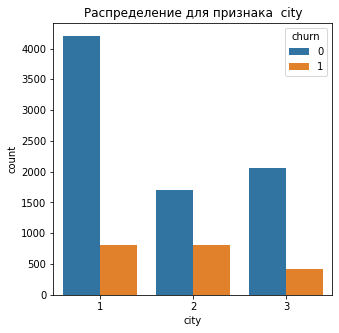

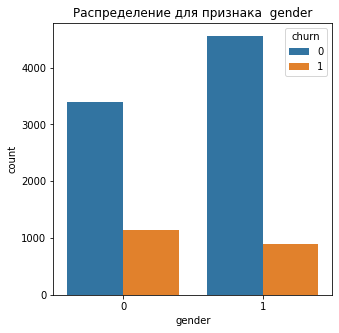

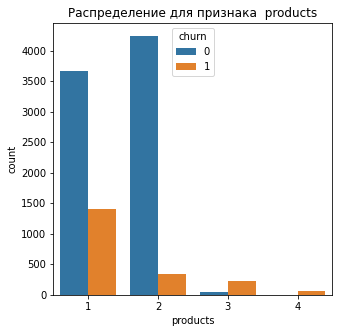

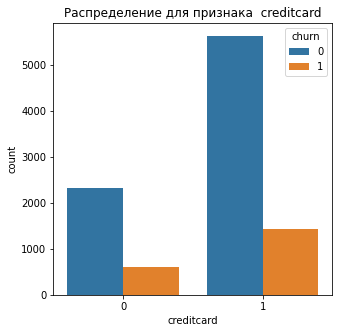

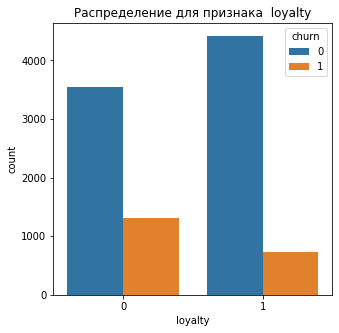

In [38]:
for column in ['city','gender','products','creditcard','loyalty']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = data[column], hue='churn', data=data)
    plt.title('Распределение для признака ' + ' ' + column, fontsize=12)
    plt.show()

По графикам можно сделать следующие выводы:

* в отток у нас попадает больше всего клиентов из Ростова Великого, затем идет Ярославль (там живет половина наших клиентов), а меньше всего в отток уходят жители Рыбинска (там живет меньше всего наших клиентов);
* женщины чаще перестают пользоваться услугами банка, чем мужчины;
* уходит больше всего клиентов, пользующихся 1 продуктом, а 3-4 продукта только у клиентов, которые ушли, поэтому можно сделать предположение, что большое число продуктов указывает на то, что клиент скорее всего уйдет;
* в отток уходят больше те клиенты, у кого есть кредитная карта;
* если клиент отмечен как "неактивный", то он уйдет с большей вероятностью.

**Теперь посмотрим отток клиентов по категории: кредитный рейтинг**

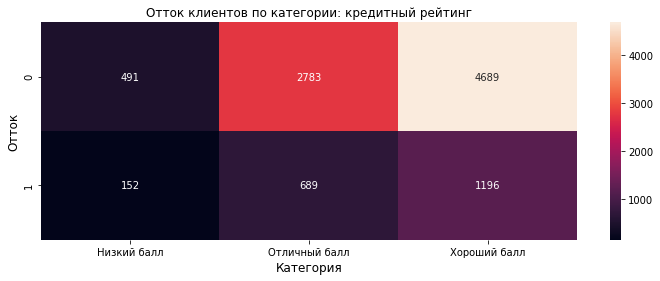

In [39]:
# сделаем сводную таблицу
score_category_data = data.pivot_table(index='churn', columns='score_category', values='userid', aggfunc='count')

# визуализируем c помощью тепловой карты, чтобы более наглядно увидеть, как меняются значения
plt.figure(figsize=(12, 4))
sns.heatmap(score_category_data, annot=True, fmt='.0f')
plt.title('Отток клиентов по категории: кредитный рейтинг')
plt.ylabel('Отток', fontsize=12)
plt.xlabel('Категория', fontsize=12)
plt.show()

От общего числа клиентов в этой категории в отток уходит:
* около 24% клиентов из категории "низкий балл";
* 20% клиентов из категории "хороший балл";
* около 20% клиентов из категории "отличный балл".

В отток чаще всего попадают клиенты из категории "низкий балл" кредитного скоринга.

**Посмотрим отток клиентов по категории возраст**

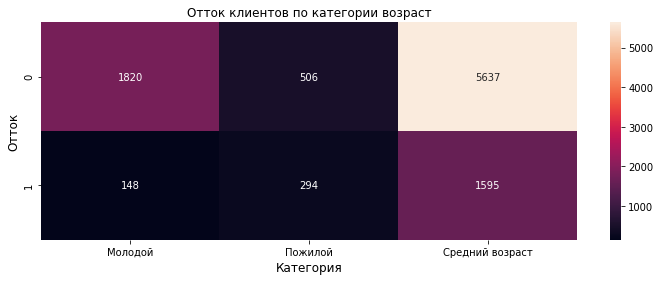

In [40]:
age_category_data = data.pivot_table(index='churn', columns='age_category', values='userid', aggfunc='count')

# визуализируем
plt.figure(figsize=(12, 4))
sns.heatmap(age_category_data, annot=True, fmt='.0f')
plt.title('Отток клиентов по категории возраст')
plt.ylabel('Отток', fontsize=12)
plt.xlabel('Категория', fontsize=12)
plt.show()

От общего числа клиентов в этой категории в отток уходит:
* около 8% клиентов из категории "молодой";
* 22% клиентов из категории "зрелый";
* около 37% клиентов из категории "пожилой".

В отток чаще всего попадают клиенты из категории "пожилой", категория "молодой" имеет наименьший уровень оттока.

**Посмотрим отток клиентов по категории: объекты в собственности**

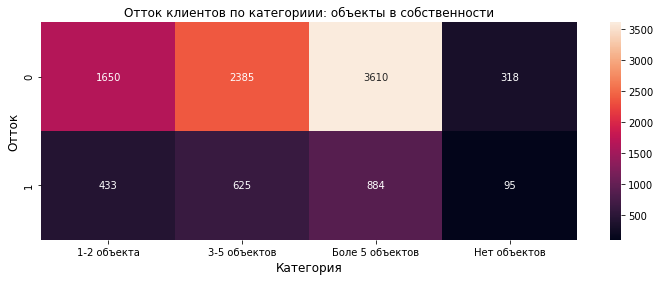

In [41]:
objects_category_data = data.pivot_table(index='churn',columns='objects_category',values='userid',aggfunc='count')

# визуализируем
plt.figure(figsize=(12, 4))
sns.heatmap(objects_category_data, annot=True, fmt='.0f')
plt.title('Отток клиентов по категориии: объекты в собственности')
plt.ylabel('Отток', fontsize=12)
plt.xlabel('Категория', fontsize=12)
plt.show()

От общего числа клиентов в этой категории в отток уходит:
* 23% клиентов из категории "нет объектов";
* около 21% клиентов из категории "1-2 объекта";
* около 21% клиентов из категории "3-4 объекта";
* около 20% клиентов из категории "более 5 объектов".

В отток чаще всего попадают клиенты из категории "нет объектов" в собственности.

**Посмотрим отток клиентов по категории: баланс на счете**

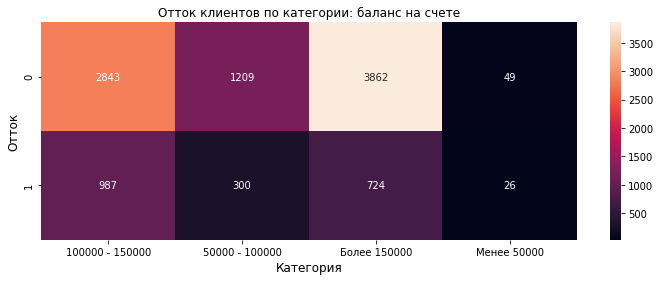

In [42]:
balance_category_data = data.pivot_table(index='churn', columns='balance_category', values='userid', aggfunc='count')

# визуализируем
plt.figure(figsize=(12, 4))
sns.heatmap(balance_category_data, annot=True, fmt='.0f')
plt.title('Отток клиентов по категории: баланс на счете')
plt.ylabel('Отток', fontsize=12)
plt.xlabel('Категория', fontsize=12)
plt.show()

От общего числа клиентов в этой категории в отток уходит:
* 1% клиентов из категории "менее 50000";
* около 20% клиентов из категории "50000-100000";
* около 26% клиентов из категории "100000-150000";
* около 75% клиентов из категории "более 150000".

В отток чаще всего попадают клиенты из категории "более 150000" на счете.

**Посмотрим отток клиентов по категории: заработная плата**

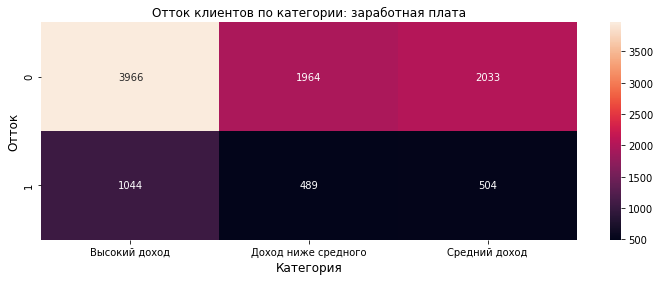

In [43]:
estimated_salary_category_data = data.pivot_table(index='churn', columns='estimated_salary_category', values='userid', aggfunc='count')

# визуализируем
plt.figure(figsize=(12, 4))
sns.heatmap(estimated_salary_category_data, annot=True, fmt='.0f')
plt.ylabel('Отток', fontsize=12)
plt.xlabel('Категория', fontsize=12)
plt.title('Отток клиентов по категории: заработная плата')
plt.show()

От общего числа клиентов в этой категории в отток уходит:
* около 20% клиентов из категории "доход ниже среднего";
* около 20% клиентов из категории "средний доход";
* 21% клиентов из категории "высокий доход".

В отток чаще всего попадают клиенты из категории "высокий доход".

### Построим матрицу корреляций

**Для выявления коррелирующих признаков построим матрицу корреляции с помощью метода .corr()**

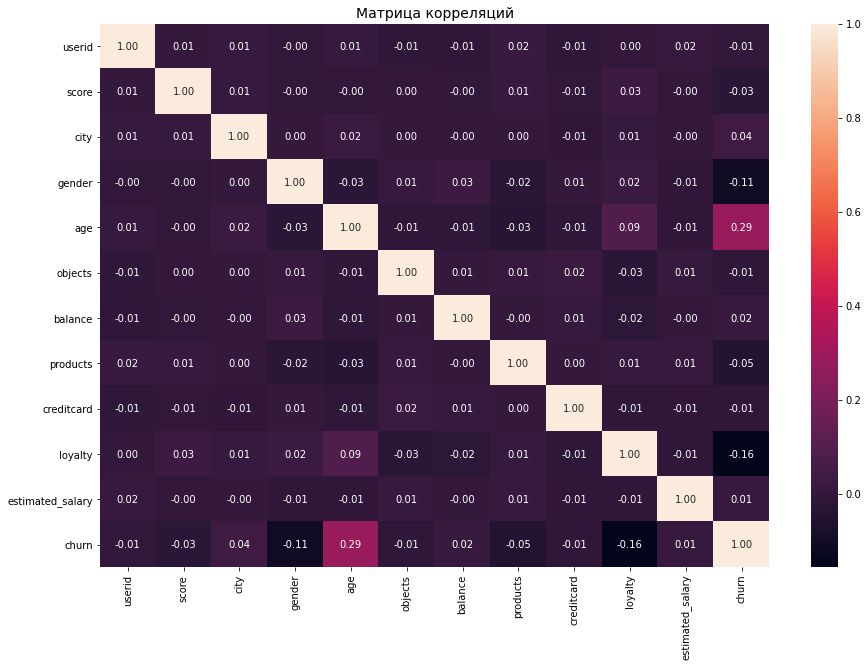

In [44]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot = True, fmt = '0.2f')
plt.title('Матрица корреляций', fontsize=14)
plt.show()

Сильной корреляции факта оттока (churn - наша целевая переменная) с другими признаками не обнаружено, но есть взаимозависимость фактора оттока с признаком age (возраст), коэффициент корреляции равен 0.29, то есть чем больше возраст, тем выше вероятность того, что клиент попадет в отток. 

Далее по значимости идут: loyalty - активность клиента (коэффициент корреляции равен -0.16) и gender - пол (коэффициент корреляции равен -0.11). Для остальных признаков характерна еще более слабая корреляция с целевой переменной.

Следовательно, у нас нет какого-то очевидного признака, по которому мы могли бы явно выявить склонность клиентов к оттоку. При этом признаков имеющих нулевую корреляцию с целевой переменной у нас тоже нет, как и сильно коррелирующих признаков между собой.
Хотя довольно странно, что баланс на счете совсем не связан с доходом, почти не связан с возрастом или активностью наших клиентов, вероятностью оттока. Age, loyalty и gender для нас важны, но в целом от модели не стоит ждать чудо.

**Вывод**

**1.Портрет среднего клиента:**

* половина клиентов в выборке из Ярославля (5014 человек), затем идет Ростов Великий (2509 человек) и Рыбинск (2477);
* клиентам от 18 до 92 лет, при этом средний возраст - 38 лет;
* 55% клиентов мужчины, остальные - женщины;
* средний балл кредитного скоринга равен 650. При этом большинство наших клиентов имеют хороший и отличный баллы кредитного рейтинга;
* заработная плата в среднем 100000 рублей. Мы также выявили, что у нас довольно много клиентов с высоким доходом (более 100000 рублей);
* средняя сумма на счете равна 119827 рублей;
* среднее количество объектов в собственности у клиентов - 5. У большинства наших клиентов более 5 объектов в собственности, но довольно много и тех, у кого 3-5;
* в среднем клиенты пользуются 1-2 продуктами;
* в среднем клиенты имеют кредитную карту - 71%;
* 52% клиентов активны, то есть пользовались нашими продуктами в последнее время.

Доля оттока по выборке составляет 20%.

**2.Портрет клиентов, которые склонны уходить в отток:**
* женщины;
* среднего возраста, ближе к 45;
* проживают в Ростове Великом;
* имеют низкий балл по кредитному скорингу;
* более 5 объектов в собственности;
* около 120000 рублей на счете;
* высокий доход (более 100000 рублей);
* пользуются 3-4 продуктами;
* являются "неактивнывным";
* имеют кредитную карту.

**Портрет клиентов, которые не склонны уходить в отток:**
* мужчины;
* среднего возраста, 37-38 лет;
* проживают в Рыбинске;
* имеют хороший балл по кредитному скорингу;
* более 5 объектов в собственности;
* 120000 рублей на счете;
* высокий доход (около 100000 рублей);
* пользуются 1-2 продуктами банка;
* являются "активными";
* имеют кредитную карту.

**3.Портрет клиентов, которые склонны уходить в отток внутри категории:**
* пожилые, от 55 лет;
* имеют низкий балл по кредитному скорингу;
* не имеют объекты в собственности;
* пользуются 3-4 продуктами;
* более 150000 рублей на счете;
* высокий уровень дохода (более 100000 рублей).

**Портрет клиентов, которые не склонны уходить в отток внутри категории:**
* молодые, от 18 до 30 лет;
* имеют отличный балл по кредитному скорингу;
* имеют более 5 объектов в собственности;
* пользуются 2 продуктами;
* менее 50000 рублей на счете;
* уровень дохода средний (от 50000 до 100000 рублей).

## Построим модель прогнозирования оттока клиентов

Построим модель прогнозирования оттока клиентов, чтобы посмотреть какие признаки могут быть для нас более важными. Для построения модели прогнозирования оттока клиентов будем использовать следующие модели бинарной классификации:
* логистическая регрессия - Logistic Regression
* модель случайного леса - Random Forest Classifier

**Удалим лишние столбцы, они больше не пригодятся**

In [45]:
data.drop('score_category', axis=1, inplace=True)
data.drop('age_category', axis=1, inplace=True)
data.drop('objects_category', axis=1, inplace=True)
data.drop('balance_category', axis=1, inplace=True)
data.drop('estimated_salary_category', axis=1, inplace=True)

### Разбьем данные на обучающую и валидационную выборку функцией train_test_split()

In [46]:
# заполним пропущенные значения на 0, чтобы не мешать обучению
data = data.fillna(0)

# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns = ['churn']) 
y = data['churn']

# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Обучим модель на train-выборке двумя способами: логистической регрессией, случайным лесом

**Логистическая регрессия - Logistic Regression**

In [47]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающие и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression()

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

**Случайный лес - Random Forest Classifier**

In [48]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

### Оценим метрики accuracy, precision, recall, F1, ROC-AUC для обеих моделей на валидационной выборке. Сравним по ним модели и определим какая модель показала себя лучше на основании метрик

Для оценки качества полученных прогнозов и выбора лучшей модели сравним следующие метрики:
* Accuracy: доля правильных ответов. Чем ближе к единице, тем лучше.
* Precision: отражает точность модели. Чем ближе к единице, тем лучше.
* Recall: полнота модели. Чем ближе к единице, тем лучше.
* F1-мера: сводная метрика, которая объединяет бы в себе информацию о точности и полноте нашего алгоритма. Чем ближе к единице, тем лучше.
* ROC-AUC: метрика оценки качества классификатора. Чем ближе к единице, тем лучше.

In [49]:
# определим функцию, которая будет выводить наши метрики
def print_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))
    
# выведем все метрики для модели логистической регрессии и модели случайного леса
print_metrics(y_test, lr_predictions, lr_probabilities, title = '\033[1m' + 'Метрики для модели логистической регрессии:' + '\033[0m')
print_metrics(y_test, rf_predictions, rf_probabilities, title = '\033[1m' + 'Метрики для модели случайного леса:' + '\033[0m')

Метрики для модели логистической регрессии:
	Accuracy: 0.81
	Precision: 0.56
	Recall: 0.18
	F1: 0.27
	ROC_AUC: 0.76
Метрики для модели случайного леса:
	Accuracy: 0.87
	Precision: 0.75
	Recall: 0.50
	F1: 0.60
	ROC_AUC: 0.86


Модель случайного леса в нашем случае ожидаемо показала результаты лучше:
* доля правильных ответов (accuracy) выше у модели логистической регрессии (87% против 81%);
* точность (precision) выше у модели случайного леса (75% против 56%);
* полнота (recall) выше у модели случайного леса (50% против 18%);
* F1-мера выше у модели случайного леса (60% против 27%);
* доля оценки качества классификатора (ROC-AUC) также выше у модели случайного леса (86% против 76%).

### Оценим важность признаков

,feature,importance
4,age,0.22
7,products,0.12
0,userid,0.12
10,estimated_salary,0.12
6,balance,0.12
1,score,0.12
5,objects,0.07
9,loyalty,0.04
2,city,0.03
3,gender,0.02


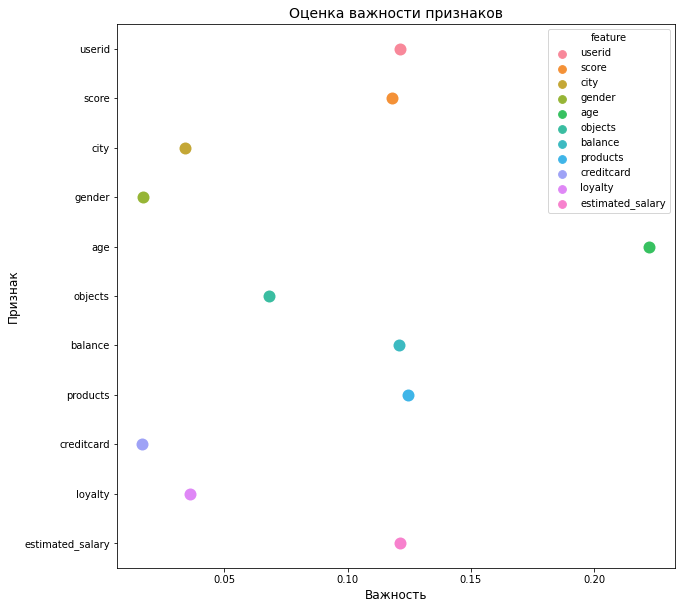

In [50]:
# для оценки важности признаков создадим датафрейм с именами признаков и их важностью, выведем по убыванию важности
rf_features = pd.DataFrame({'feature' : X_train.columns, 'importance' : rf_model.feature_importances_})
display(rf_features.sort_values('importance', ascending = False))

# построим график swarmplot
plt.figure(figsize=(10,10))
sns.swarmplot(x="importance", y="feature", data=rf_features, hue="feature", size=12)
plt.title('Оценка важности признаков', fontsize=14)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.show()

Видим среди важных признаков, которые особо влияют на прогноз модели:
* возраст (age);
* количество продуктов, которыми пользуется клиент (products);
* идентификатор пользователя (userid);
* заработная плата клиента (estimated_salary);
* баланс на счете (balance);
* баллы кредитного скоринга (score).

**Вывод**

При построении модели мы разделили выборку на обучающую и валидационную в соотношении 80 к 20, то есть на 80% данных модель была обучена, а на 20% - проверена. После этого были построены и обучены 2 модели: алгоритмом логистической регрессии и алгоритмом случайного леса.

Основные метрики полученных моделей следующие. Для модели логистической регрессии:
* Accuracy = 0.81; 
* Precision = 0.56; 
* Recall = 0.18; 
* F1 = 0.27; 
* ROC_AUC = 0.76. 


Для модели случайного леса: 
* Accuracy = 0.87; 
* Precision = 0.75; 
* Recall = 0.50; 
* F1 = 0.60; 
* ROC_AUC = 0.86. 

Таким образом, модель случайного леса подходит больше почти по всем показателям: точности (precision), полноте (recall), агрегирующей метрике F1 и наиболее точной метрике оценки качества классификатора ROC-AUC.

Среди важных признаков, которые особо влияют на прогноз модели случайного леса видим:
* возраст (age);
* количество продуктов, которыми пользуется клиент (products);
* идентификатор пользователя (userid);
* заработная плата клиента (estimated_salary);
* баланс на счете (balance);
* баллы кредитного скоринга (score).

## Сделаем кластеризацию клиентов

### Стандартизируем данные

In [51]:
# создим объект класса Scaler
sc = StandardScaler()

# обучаем нормализатор и преобразуем набор данных без учета оттока, чтобы это не повлияло на модель
X_sc = sc.fit_transform(data.drop(columns = 'churn')) 

### Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму

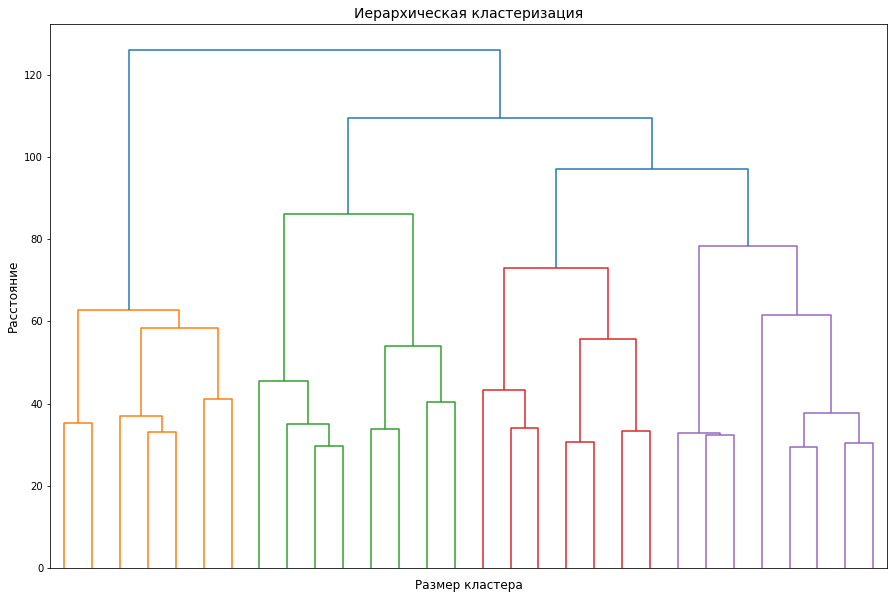

In [52]:
# расчитаем матрицу расстояний с помощью метода linkage
linked = linkage(X_sc, method = 'ward')

# построим дендрограмму
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top', show_leaf_counts=False, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=14)
plt.title('Иерархическая кластеризация', fontsize=14)
plt.xlabel('Размер кластера', fontsize=12)
plt.ylabel('Расстояние', fontsize=12)
plt.show()

Мы имеем 4 разных цвета на графике, предложенное оптимальное число кластеров - 4.

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. За число кластеров возьмем n=4

Алгоритм K-Means группирует пошагово все объекты. Вот принцип его работы:
* Есть K кластеров. Алгоритм пошагово подбирает их центры и относит объекты к тому кластеру, чей центр ближе.
* Центры корректируются (меняют свое положение) до тех пор, пока это позволяет минимизировать среднее расстояние от объектов каждого кластера до его центра.
* Когда расстояние от объектов до центра перестает снижаться или сокращается несущественно, алгоритм останавливается и фиксирует разбиение, считая его оптимальным.

**Выполним кластеризацию по алгоритму K-Means**

In [53]:
# задаем число кластеров, равное 4, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters = 4, random_state = 0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 3)
labels = km.fit_predict(X_sc)

# присвоим каждому наблюдению в датафрейме соответствующее значение кластера 
data['cluster_km'] = labels

### Посмотрим на средние значения признаков для кластеров

In [54]:
cluster_means = data.groupby(['cluster_km']).mean().sort_values('churn').T
cluster_means

cluster_km,1,3,2,0
userid,15735672.40,15732880.99,15735237.63,15730822.35
score,652.52,651.72,651.39,646.49
city,1.67,1.79,1.76,1.75
gender,0.54,0.56,0.54,0.53
age,38.03,39.81,39.07,38.64
objects,5.15,4.92,4.91,5.11
balance,10486.23,105491.59,78715.94,103847.86
products,2.15,1.28,1.50,1.26
creditcard,0.98,1.00,0.00,1.00
loyalty,0.53,1.00,0.52,0.00


**Кластер 0 характеризуется:**
* средний балл кредитного скоринга равен 646 (score);
* приблизительно равным распределением между мужчинами и женщинами (gender);
* средний возраст клиентов - 38 лет (age);
* среднее количество объектов в собственности равно 5 (objects);
* средняя сумма на счете клиента равна 103847 у.е. (balance);
* количество продуктов, которыми пользуется клиент равно 1 (products);
* наличием кредитных карт у всех клиентов (creditcard);
* клиенты не пользовались продуктами нашего банка в последнее время (loyalty);
* средняя заработная плата клиентов равна 101281 р.

Доля оттока 32% (самый высокий отток).

**Кластер 1 характеризуется:**
* средний балл кредитного скоринга равен 652 (score);
* приблизительно равным распределением между мужчинами и женщинами (gender);
* средний возраст клиентов - 38 лет (age);
* среднее количество объектов в собственности равно 5 (objects);
* средняя сумма на счете клиента равна 10486 у.е. (balance);
* количество продуктов, которыми пользуется клиент равно 2 (products);
* наличием кредитных карт у 98% клиентов (creditcard);
* 53% клиентов пользовались продуктами нашего банка в последнее время (loyalty);
* средняя заработная плата клиентов равна 99068 р.

Доля оттока 13% (самый низкий отток).


**Кластер 2 характеризуется:**
* средний балл кредитного скоринга равен 651 (score);
* приблизительно равным распределением между мужчинами и женщинами (gender);
* средний возраст клиентов - 39 лет (age);
* среднее количество объектов в собственности равно 4 (objects);
* средняя сумма на счете клиента равна 78715 у.е. (balance);
* количество продуктов, которыми пользуется клиент равно 1 (products);
* нет кредитных карт у клиентов (creditcard);
* 52% клиентов пользовались продуктами нашего банка в последнее время (loyalty);
* средняя заработная плата клиентов равна 100958 р.

Доля оттока 20%.


**Кластер 3 характеризуется:**
* средний балл кредитного скоринга равен 651 (score);
* приблизительно равным распределением между мужчинами и женщинами (gender);
* средний возраст клиентов - 39 лет (age);
* среднее количество объектов в собственности равно 4 (objects);
* средняя сумма на счете клиента равна 105491 у.е. (balance);
* количество продуктов, которыми пользуется клиент равно 1 (products);
* наличием кредитных карт у 100% клиентов (creditcard);
* все клиенты пользовались продуктами нашего банка в последнее время (loyalty);
* средняя заработная плата клиентов равна 98811 р.

Доля оттока 16%.

### Построим распределения признаков для кластеров

**Напишем цикл для построения графиков**

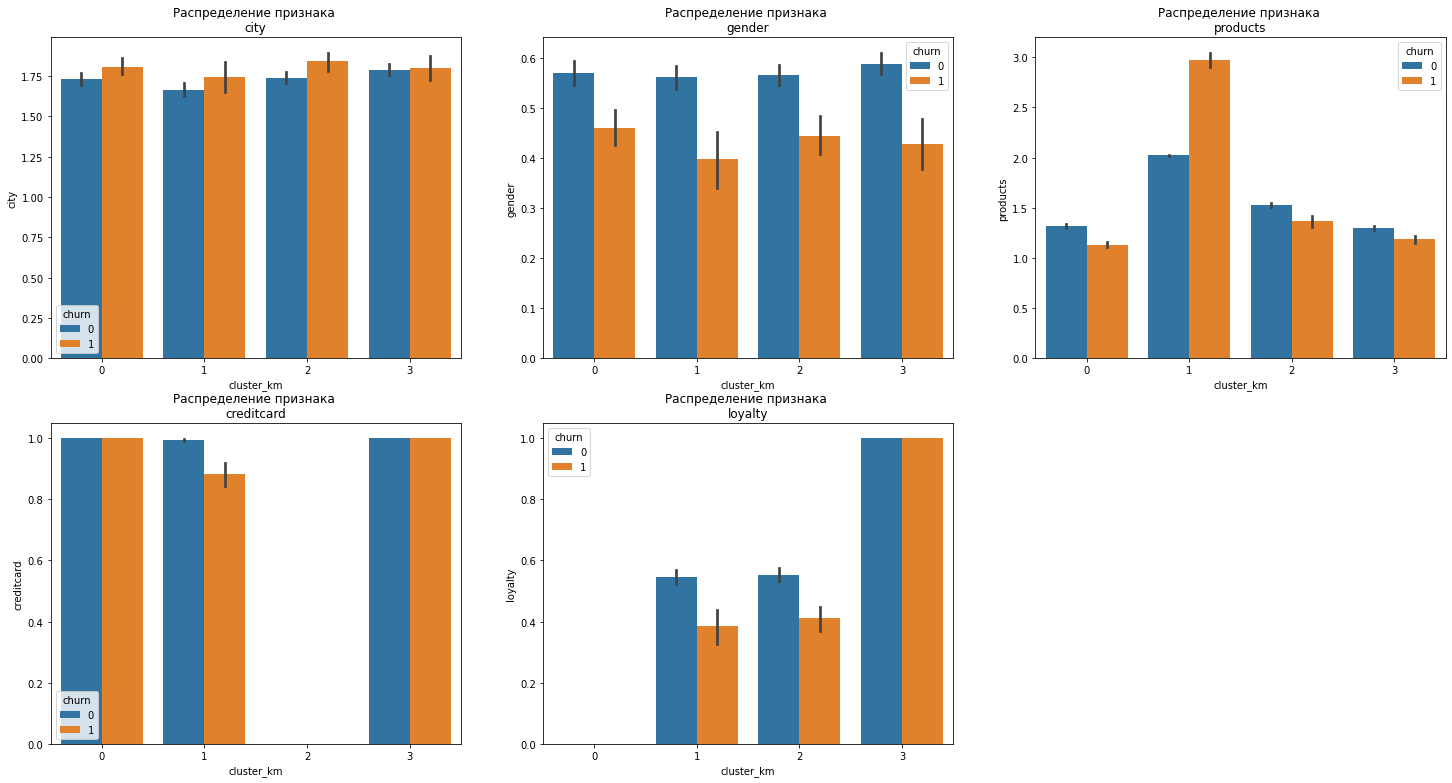

In [55]:
# список с признаками
list_1 = ['city', 'gender', 'products', 'creditcard', 'loyalty']

# цикл для построения графиков
for i, col in enumerate(list_1):
    plt.subplot(2, 3, i+1)
    fig = plt.gcf()
    fig.set_size_inches(25,13)
    sns.barplot(data = data, x = 'cluster_km', y = col, hue = 'churn')
    plt.title('Распределение признака \n'+ str(col))

**Напишем цикл для построения графиков**

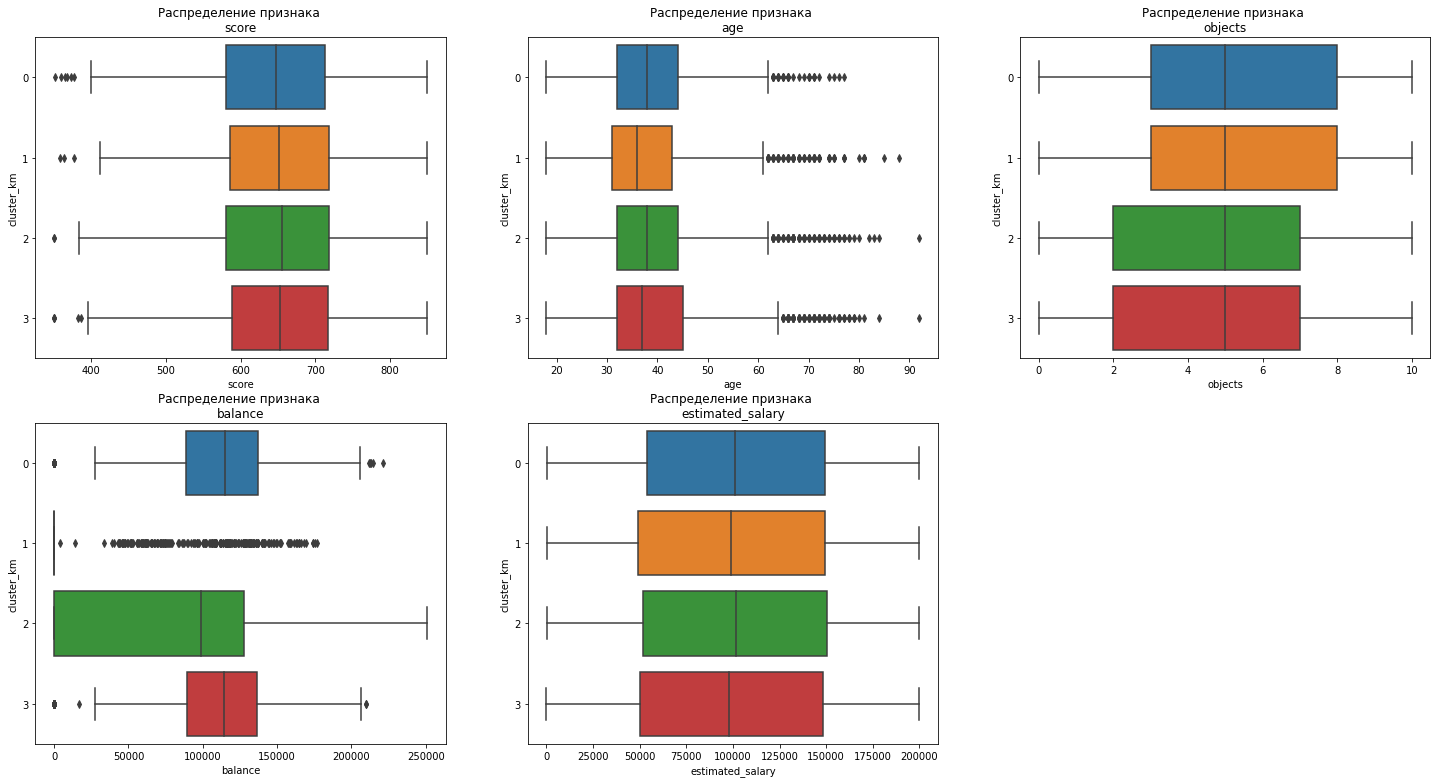

In [56]:
# список с признаками
list_2 = ['score', 'age', 'objects', 'balance', 'estimated_salary']

# цикл для построения графиков
for i, col in enumerate(list_2):
    plt.subplot(2, 3, i+1)
    fig = plt.gcf()
    fig.set_size_inches(25, 13)
    sns.boxplot(data = data, x = col, y = 'cluster_km', orient = 'h')
    plt.title('Распределение признака \n'+ str(col))

* Средний уровень кредитного скоринга выше в кластерах с меньшим оттоком;
* В целом пол распределен почти равномерно, немного выделяется только 3 кластер;
* Средний возраст в кластерах 3, 2, 0 выше, чем в кластере 1, где отток ниже;
* Количество объектов и продуктов не так сильно влияют на отток, хотя для кластера 0 с наибольшим оттоком наблюдается снижение количества продуктов;
* Для кластера 0 характерно отсутствием активности, наличие кредитных карт;
* Кластер 3 отличается высокой активностью, наличием кредитных карт;
* Клиенты в кластер 1 также имеют кредитные карты, но не проявляют высокой активности;
* Клиенты в кластере 2 не имеют кредитных карт, но имеют средний уровень активности;
* Средняя заработная плата в кластере 0 немного выше, чем в кластерах 1, 2, 3.

###  Для каждого полученного кластера посчитайте долю оттока (методом groupby())

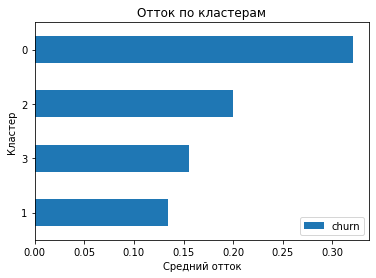

In [57]:
data.groupby(['cluster_km']).agg({'churn' : 'mean'}).sort_values('churn').plot(kind = 'barh')
plt.title('Отток по кластерам')
plt.xlabel('Средний отток')
plt.ylabel('Кластер')
plt.show()

Кластеры, которые склонны к оттоку, это следующие:

* кластер 0 с вероятностью 32%
* кластер 1 с вероятностью 13%, является самым надежным
* кластер 2 с вероятностью 20%
* кластер 3 с вероятностью 16%, является надежным

**Вывод**

Нулевой кластер больше всего склонен к оттоку: доля составляет 32%. Второй кластер характеризуется долей оттока в 20%. Первый и третий кластеры (доля оттока 13% и 16% соответственно) являются самыми надежными.

В целом, видим, что сегментация не такая осмысленная, но действительно кроме демографических характеристик скорее имеет значение балл кредитного скоринга, также "активность" клиента, количество продуктов, которыми пользуется клиент, в меньшей степени - количество объектов в собственности, заработная плата и баланс на счете, наличие кредитной карты.

## Формулировка и проверка статистических гипотез

### Гипотеза различия дохода между теми клиентами, которые ушли и теми, которые остались

**Посмотрим на распределение уровня дохода клиентов**

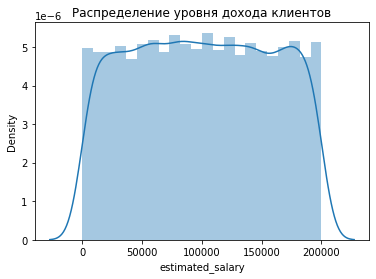

In [58]:
sns_plot = sns.distplot(data['estimated_salary'])
fig = sns_plot.get_figure()
plt.title('Распределение уровня дохода клиентов')
plt.show()

Распределение не идеальное, но приближенно к нормальному. При проверке гипотез можем использовать Критерий Стьюдента (t-тест) или U-критерий Манна-Уитни (Mann–Whitney U-test). U-критерий Манна-Уитни - наиболее мощная (чувствительная) непараметрическая альтернатива t-критерия для независимых выборок и фактически, в некоторых случаях он имеет большую мощность ("Непараметрические методы статистики" - Холлендер М., Вульф Д.А. (1983 г.). U-критерий является ранговым, поэтому ключевая идея в следующем: проранжировать две выборки по порядку от меньшего к большему и сравнить ранги одних и тех же значений, попавших в обе выборки.

Сформулируем нулевую гипотезу:
* H0  — Между доходом клиентов, которые ушли и которые остались нет статистически значимых различий.

Сформулируем альтернативную гипотезу:
* H1  — Между доходом клиентов, которые ушли и которые остались есть статистически значимые различия.

Критический уровень статистической значимости зададим равный 5%.

In [59]:
alpha = 0.05 # критический уровень статистической значимости

results = st.mannwhitneyu(data[data['churn']==1]['estimated_salary'], data[data['churn']==0]['estimated_salary'])
pvalue = results.pvalue

print('p-значение: ', pvalue)

if (pvalue < alpha):
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение:  0.22705150930153783
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


**Посмотрим на средние и медианные значения у тех клиентов кто ушел в отток и тех, кто не ушел**

In [60]:
# средние значения
print('Среднее значение дохода у тех, кто ушел в отток:', data[data['churn']==1]['estimated_salary'].mean())
print('Среднее значение дохода у тех, кто не ушел в отток:', data[data['churn']==0]['estimated_salary'].mean())

# медианные значения
print('Медианное значение дохода у тех, кто ушел в отток:', data[data['churn']==1]['estimated_salary'].median())
print('Медианное значение дохода у тех, кто не ушел в отток:', data[data['churn']==0]['estimated_salary'].median())

Среднее значение дохода у тех, кто ушел в отток: 101465.67753068237
Среднее значение дохода у тех, кто не ушел в отток: 99738.39177194524
Медианное значение дохода у тех, кто ушел в отток: 102460.84
Медианное значение дохода у тех, кто не ушел в отток: 99645.04


Доход клиентов, которые ушли немного превышает доход клиентов, которые остались, но в данном случае мы действительно не можем говорить о статистически значимой разнице.

### Гипотеза о различии возраста между теми клиентами, которые ушли и теми, которые остались

**Посмотрим на распределение возраста клиентов**

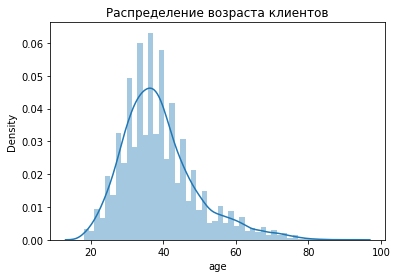

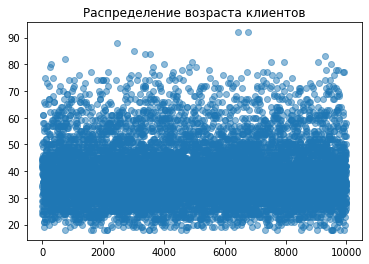

In [61]:
sns_plot = sns.distplot(data['age'])
fig = sns_plot.get_figure()
plt.title('Распределение возраста клиентов')
plt.show()

x_values = pd.Series(range(0,len(data['age'])))
plt.scatter(x_values, data['age'], alpha=0.5)
plt.title('Распределение возраста клиентов')
plt.show()

Распределение несовсем равномерное, поэтому будем использовать U-критерий Манна-Уитни.

Сформулируем нулевую гипотезу:
* H0  — Между возрастом клиентов ушедших в отток и оставшихся нет статистически значимых различий.

Сформулируем альтернативную гипотезу:
* H1  — Между возрастом клиентов ушедших в отток и оставшихся есть статистически значимые различия. 

Критический уровень статистической значимости - 5%.

In [62]:
alpha = 0.05 # критический уровень статистической значимости

results = st.mannwhitneyu(data[data['churn']==1]['age'], data[data['churn']==0]['age'])
pvalue = results.pvalue

print('p-значение: ', pvalue)

if (pvalue < alpha):
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение:  3.2104014319371675e-230
Отвергаем нулевую гипотезу: разница статистически значима


**Посмотрим на средний и медианный возраст**

In [63]:
display(data.pivot_table(index='churn', values='age', aggfunc='mean'))
display(data.pivot_table(index='churn', values='age', aggfunc='median'))

,age
churn,
0,37.41
1,44.84


,age
churn,
0,36
1,45


Видим, что действительно разница в возрасте наших клиентов составляет около 10 лет.

**Вывод**

* Не получилось отвергнуть нулевую гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались. Вывод о различии сделать нельзя.
* Отвергли гипотезу о различии возраста между теми клиентами, которые ушли и теми, которые остались. Разница статистически значима.

## Сформулируем выводы и предложим рекомендации для стратегии взаимодействия с клиентами и их удержания

### Общий вывод

Заказчик подготовил для нас файл, который содержит данные с информацией о клиентах банка «Метанпром» за предыдущий до проверки факта оттока период. Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Данные представлены в виде таблицы, включающей в себя 10000 строк и 12 столбцов, в которых содержится следующая информация: идентификатор пользователя, баллы кредитного скоринга клиентов, город, пол, возраст, количество объектов в собственности, баланс на счете, количество продуктов, которыми пользуется клиент, есть ли у него кредитная карта, является ли он активным (пользовался услугами нашего банка в последнее время), заработная плата клиента, а также ушел или нет (факт оттока).

**По результатам исследования получили следующие портреты клиентов**

**1.Портрет среднего клиента:**

* половина клиентов в выборке из Ярославля (5014 человек), затем идет Ростов Великий (2509 человек) и Рыбинск (2477);
* клиентам от 18 до 92 лет, при этом средний возраст - 38 лет (age);
* 55% клиентов мужчины, остальные - женщины;
* средний балл кредитного скоринга равен 650. При этом большинство наших клиентов имеют хороший и отличный баллы кредитного рейтинга;
* заработная плата в среднем 100000 рублей. Мы также выявили, что у нас довольно много клиентов с высоким доходом (более 100000 рублей);
* средняя сумма на счете равна 119827 у.е.;
* среднее количество объектов в собственности у клиентов - 5. У большинства наших клиентов более 5 объектов в собственности, но довольно много и тех, у кого 3-5;
* в среднем клиенты пользуются 1-2 продуктами;
* в среднем клиенты имеют кредитную карту - 71%;
* 52% клиентов активны, то есть пользовались нашими продуктами в последнее время (loyalty).

Доля оттока по выборке составляет 20%.

**2.Портрет клиентов, которые склонны уходить в отток:**
* женщины;
* среднего возраста, ближе к 45;
* проживают в Ростове Великом;
* имеют низкий балл по кредитному скорингу;
* более 5 объектов в собственности;
* около 120000 рублей на счете;
* высокий доход (более 100000 рублей);
* пользуются 3-4 продуктами;
* являются "неактивнывными";
* имеют кредитную карту.

**Портрет клиентов, которые не склонны уходить в отток:**
* мужчины;
* среднего возраста, 37-38 лет;
* проживают в Рыбинске;
* имеют хороший балл по кредитному скорингу;
* более 5 объектов в собственности;
* 120000 рублей на счете;
* высокий доход (около 100000 рублей);
* пользуются 1-2 продуктами банка;
* являются "активными";
* имеют кредитную карту.

**3.Портрет клиентов, которые склонны уходить в отток внутри категории:**
* пожилые, от 55 лет;
* имеют низкий балл по кредитному скорингу;
* не имеют объекты в собственности;
* пользуются 3-4 продуктами;
* более 150000 рублей на счете;
* высокий уровень дохода (более 100000 рублей).

**Портрет клиентов, которые не склонны уходить в отток внутри категории:**
* молодые, от 18 до 30 лет;
* имеют отличный балл по кредитному скорингу;
* имеют более 5 объектов в собственности;
* пользуются 2 продуктами;
* менее 50000 рублей на счете;
* уровень дохода средний (от 50000 до 100000 рублей).

Выделение признаков, сегментация на основании алгоритмов получилась не такая осмысленная, как та, что мы сделали вручную, но увидели, что действительно кроме демографических характеристик скорее имеет значение балл кредитного скоринга, также "активность" клиента, количество продуктов, которыми пользуется клиент, в меньшей степени - количество объектов в собственности, заработная плата и баланс на счете, наличие кредитной карты.

**3. В результате проверки статистических гипотез:**
* Не получилось отвергнуть нулевую гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались. Вывод о различии сделать нельзя.
* Отвергли гипотезу о различии возраста между теми клиентами, которые ушли и теми, которые остались. Разница статистически значима.

**4. Рекомендации по сбору данных:**
* Были обнаружены пропущенные значения в столбце, который отражает баланс на счете клиента. Стоит разобраться с причиной этих пропусков, тогда можно будет доработать модель, еще раз проранжировать признаки.
* Также мы выявили что минимальная заработная плата у 694 клиентов оказалась ниже минимального размера оплаты труда (13890 рублей в месяц). У таких клиентов на счетах лежат довольно крупные суммы, большое количество объектов в собственности, поэтому необходимо также обратить внимание и более подробно изучить причины такой аномалии, если часть этих данных была получена в результате оценки некой модели, то ее стоит доработать.
* Для более качественного и подробного анализа следует уточнить информацию о том, что именно за продукты мы уже предоставляем клиентам.

### Базовые рекомендации для стратегии взаимодействия с клиентами и их удержания

1. Необходимо пересмотреть продукты, то есть провести модификацию существующих банковских продуктов с учетом потребностей клиентов возрастных группы как в целом, так и для отдельных ее сегментов. Кроме того, можно изучить является ли такой отток общеотраслевой тенденцией, если да, то изучить решение этой проблемы в отрасли и рассмотреть возможность внедрения этих решений в нашем банке. Если проблема характерна для нашего банка, то необходимо провести исследование на предмет дополнительных важных факторов, которые могут влиять на отток. Например, есть ли у нашего банка удобное приложение и сайт, предлагаем ли мы актуальные для каждого сегмента продукты (менеджеры могут обзвонить часть людей из каждого сегмента, чтобы понять причины их оттока, затем уже это позволит сформировать более качественное предложение или разработать новые продукты), даем ли льготные условия необходимым категориям (студентам, пенсионерам).

1. Чтобы снизить отток, повысить "активность" женщин с высоким уровнем дохода и суммой на счете, можем предложить бесплатное обслуживание при ежемесячном выполнении одного из ряда условий, например, оплаты покупок картой от 100000 рублей, поступления зарплаты на карту от 100000 рублей, наличием акций, купленных через нашего брокера, на сумму от 50000 рублей или средств на счетах и вкладах от 120000 рублей.

2. Для удержания и успешного взаимодействия с клиентами мужчинами, которые уже более активны и менее склонны к оттоку, можем предложить лимитированные премиальные карты с персональным обслуживанием, большим кэшбэком, большей доходностью по вкладу, повышением лимита на снятие наличных при балансе на счетах более 150000 рублей, покупках на сумму от 100 000 рублей в месяц, при этом учитывая неоднородность сегмента по составу и характеристикам (здесь можно подобрать персональные партнерские программы).

3. Для пожилых людей можем предложить повышенные ставки по вкладам и начислять проценты пенсионерам на остаток средств на счете согласно тарифам по вкладу, пересмотреть продукты, подобрать более подходящие программы лояльности (возможно, такие клиенты часто путешествуют, живут в апартаментах или являются предпринимателями).

4. Для молодых людей от 18 до 30 со средним уровнем дохода можем увеличить кэшбэк за театры, концерты, кино, и другие мероприятия, оплату доставки из ресторанов и кафе, бесплатное обслуживание и при высоком балле кредитного скоринга предложить кредитную карту с беспроцентным обслуживанием и кэшбеком у партнеров, но здесь важно не переборщить с количеством предлагаемых продуктов, так как, например, при использовании 4 продуктов у клиентов 100% отток, а отличный балл по кредитному скорингу может быть связан с возрастом, наличием большого количества объектов в собственности, занимаемой должности.